# Import Packages

In [14]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


# Import Data after Webscraping

In [16]:
json1_file = open("Friends_transcripts.json")
json1_str = json1_file.read()
json1_data = json.loads(json1_str)
json1_data.keys()

dict_keys(['Episodes', 'Episode_Names', 'Characters', 'Lines'])

# Data Inspection

In [17]:
pd.set_option('display.max_colwidth', -1)
data = pd.DataFrame.from_dict(json1_data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48944 entries, 0 to 48943
Data columns (total 4 columns):
Episodes         48944 non-null object
Episode_Names    48944 non-null object
Characters       48944 non-null object
Lines            48944 non-null object
dtypes: object(4)
memory usage: 1.5+ MB


In [18]:
data.head()

,Episodes,Episode_Names,Characters,Lines
0,101,Monica Gets A Roommate,Monica,There's nothing to tell! He's just some guy\nI work with!
1,101,Monica Gets A Roommate,Joey,"C'mon, you're going out with the guy! There's\ngotta be something wrong with him!"
2,101,Monica Gets A Roommate,Chandler,"All right Joey, be\nnice. So does he have a hump? A hump and a hairpiece?"
3,101,Monica Gets A Roommate,Phoebe,"Wait, does he eat chalk?"
4,101,Monica Gets A Roommate,Phoebe,"Just, 'cause, I don't want her to go through\nwhat I went through with Carl- oh!"


> It seems that character names are sometimes written in captial cases. and sometimes in lower case.

In [19]:
# Lets make the character names consistent and add a new column 'Season'
data.Characters = data.Characters.apply (lambda x:  str.upper(x))
data['Season']= data.Episodes. apply(lambda x: int(x[0]))
data_columns = list(data.columns)
data_columns

['Episodes', 'Episode_Names', 'Characters', 'Lines', 'Season']

Text(0.5,1,'Total Number of Lines for Top 15 Characters in the Show ')

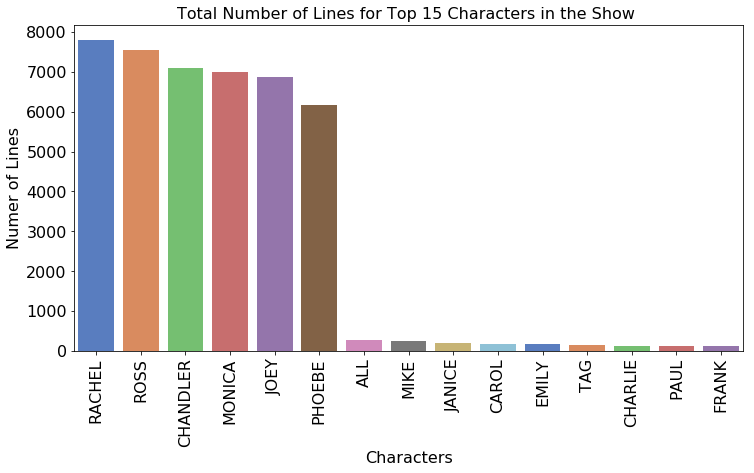

In [20]:
Characters_per_rank = (data.Characters.value_counts()).index 
data_for_count_plot = data[data.Characters.isin (Characters_per_rank[0:15])]
plt.figure(figsize = (12, 6))
sns.countplot(x= 'Characters', order = Characters_per_rank[0:15], palette = 'muted', data = data_for_count_plot)
plt.xlabel("Characters", fontsize=16)
plt.ylabel("Numer of Lines", fontsize=16)
plt.xticks(rotation = 90,  fontsize=16)
plt.yticks(  fontsize= 16)
plt.title("Total Number of Lines for Top 15 Characters in the Show ",fontsize=16)

In [21]:
data_lines_per_season = pd.pivot_table(data_for_count_plot,index=["Characters","Season"],values=["Lines"],aggfunc='count')
data_lines_per_season = data_lines_per_season.reset_index()
data_lines_per_season_pivot = data_lines_per_season.pivot(index='Season', columns='Characters', values='Lines')

In [22]:
data_lines_per_season_pivot.head()

Characters,ALL,CAROL,CHANDLER,CHARLIE,EMILY,FRANK,JANICE,JOEY,MIKE,MONICA,PAUL,PHOEBE,RACHEL,ROSS,TAG
Season,,,,,,,,,,,,,,,
1,91.0,79.0,817.0,NaN,NaN,NaN,38.0,640.0,NaN,872.0,17.0,637.0,850.0,952.0,NaN
2,8.0,29.0,170.0,NaN,NaN,NaN,7.0,172.0,NaN,156.0,NaN,136.0,177.0,278.0,NaN
3,55.0,27.0,825.0,NaN,NaN,79.0,62.0,775.0,3.0,847.0,NaN,793.0,925.0,1075.0,NaN
4,39.0,11.0,912.0,NaN,138.0,28.0,27.0,816.0,4.0,766.0,NaN,711.0,908.0,807.0,NaN
5,47.0,7.0,941.0,NaN,29.0,25.0,14.0,932.0,NaN,898.0,NaN,813.0,906.0,870.0,NaN


<Figure size 864x432 with 0 Axes>

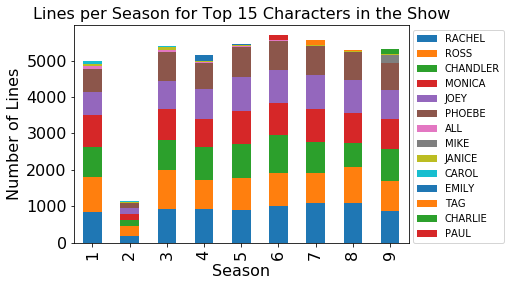

In [23]:
data_lines_per_season_pivot = data_lines_per_season.pivot(index='Season', columns='Characters', values='Lines')
data_lines_per_season_pivot.fillna(0)

#sns.set()
plt.figure(figsize=(12,6))
data_lines_per_season_pivot.loc[:,Characters_per_rank[:14]].plot.bar(stacked=True)

plt.xlabel( "Season",fontsize=16)
plt.ylabel("Number of Lines", fontsize=16)
plt.xticks(  fontsize= 16,rotation = 90)
plt.yticks(  fontsize= 16)
plt.title("Lines per Season for Top 15 Characters in the Show",fontsize=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1),prop={'size':10})

# Data Cleaning

In [24]:
# Define a function to return the wordnet object value corresponding to the POS tag

import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):
        
        return wordnet.ADJ

    elif pos_tag.startswith('V'):

        return wordnet.VERB

    elif pos_tag.startswith('N'):

        return wordnet.NOUN

    elif pos_tag.startswith('R'):

        return wordnet.ADV

    else:

        return wordnet.NOUN

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [WinError 10060] A connection attempt failed because
[nltk_data]     the connected party did not properly respond after a
[nltk_data]     period of time, or established connection failed
[nltk_data]     because connected host has failed to respond>
[nltk_data] Error loading wordnet: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [25]:
# write a function to clean text    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):

    # lower text
    text = text.lower()

    # tokenize text for space and \n
    text = re.split('\s+|\n',text)
    
    # remove puncutation
    text = [word.strip(string.punctuation) for word in text]

    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]

    # remove stop words
    stop = set(stopwords.words('english'))
    text = [x for x in text if x not in stop]

    # remove empty tokens
    text = [t for t in text if len(t) > 0]

    # pos tag text
    pos_tags = pos_tag(text)

    # create a (word, pos_tag) tuple for each word in text and then lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]

    # remove words with only one letter
    text = [t for t in text if len(t) > 1]

    # join all
    text = " ".join(text)

    return(text)

# call the function to clean text data
data["Lines"] = data["Lines"].apply(lambda x: clean_text(x))
data["Lines"].head()

# Eliminate any row with no entry fordata['Lines'] after cleaning 
data['Lines'].replace('', np.NaN, inplace=True)
data.dropna(inplace=True)

In [26]:
data.head()

,Episodes,Episode_Names,Characters,Lines,Season
0,101,Monica Gets A Roommate,MONICA,there's nothing tell he's guy work,1
1,101,Monica Gets A Roommate,JOEY,c'mon go guy there's gotta something wrong,1
2,101,Monica Gets A Roommate,CHANDLER,right joey nice hump hump hairpiece,1
3,101,Monica Gets A Roommate,PHOEBE,wait eat chalk,1
4,101,Monica Gets A Roommate,PHOEBE,cause want go go carl oh,1


In [31]:
# keep a list of all words and a set for all characters for future use in the code
import itertools
line_tokenized = [ re.split(' ',text) for text in data['Lines'].dropna()]
all_words = list(itertools.chain.from_iterable(line_tokenized))
all_characters = set(data.Characters)

# Interactive EDA: Visualize Word/Letter Density for Different Actors

In [28]:
# create figure
import ipywidgets as widgets
from ipywidgets import interact

def word_letter_density_distribution(Character_Name):
    f, ax1 = plt.subplots(figsize=(12,5))

    if Character_Name in all_characters:
        letter_count  = data["Lines"][data.Characters == Character_Name].str.len()
        word_count    =  data["Lines"][data.Characters == Character_Name].str.split(' ').str.len()
    else:
        letter_count  = data["Lines"].str.len()
        word_count    =  data["Lines"].str.split(' ').str.len()
    plt1 = sns.distplot(letter_count[letter_count<1000], ax=ax1, label='letters')
    plt2 = sns.distplot(word_count[word_count<1000], ax=ax1, color='orange', label='words')

    # add legend, title, and labels
    legend = plt.legend( prop={'size': 16})
    title = plt.title('Density of word and letter counts in lines of the transcripts')
    labels = ax1.set(xlabel='Number of Letters or Words', ylabel='Density')

    ax1.set_xlim(0, 200)
    ax1.set_ylim(0, 0.25)

    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(16)
      
# features to visualize
Selection_Options = list(Characters_per_rank[:20])
Selection_Options.append('All Characters')
style = {'description_width': 'initial'}
warnings.filterwarnings('ignore')
interact(word_letter_density_distribution, Character_Name = Selection_Options,style = style)


interactive(children=(Dropdown(description='Character_Name', options=('RACHEL', 'ROSS', 'CHANDLER', 'MONICA', …

<function __main__.word_letter_density_distribution(Character_Name)>

# Cumulative Distribution of Word Density for Lines in the Transcript

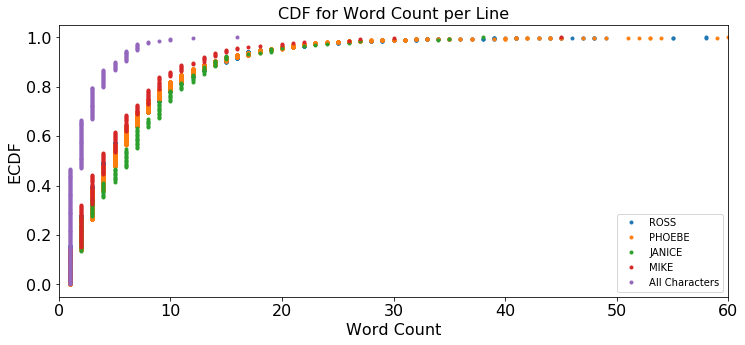

In [29]:
def ECDF(Character_Name1):
    if Character_Name1 in all_characters:
        word_count1    =  data["Lines"][data.Characters == Character_Name1].str.split(' ').str.len() 
    else: 
        word_count1    =  data["Lines"].str.split(' ').str.len()
    
           
    x1 = np.sort(word_count1)
    n1 = len(word_count1)
    y1 = np.arange(1, n1+1) / n1
    return x1,y1
    

x1,y1 = ECDF('ROSS')
x2,y2 = ECDF('PHOEBE')
x3,y3 = ECDF ('JANICE')
x4,y4 = ECDF ('MIKE')
x5,y5 = ECDF('ALL')

plt.figure(figsize = (12,5))

plt.plot(x1 , y1,marker = '.' , linestyle = 'none', label = 'ROSS')
plt.plot(x2 , y2 ,marker = '.' , linestyle = 'none', label = 'PHOEBE')
plt.plot(x3 , y3 ,marker = '.' , linestyle = 'none', label = 'JANICE')
plt.plot(x4 , y4,marker = '.' , linestyle = 'none', label = 'MIKE')
plt.plot(x5 , y5 ,marker = '.' , linestyle = 'none', label = 'All Characters')

# Label the axes
plt.xlabel('Word Count', fontsize= 16)
plt.ylabel('ECDF',fontsize= 16)
plt.xticks(  fontsize= 16)
plt.yticks(  fontsize= 16)
plt.title("CDF for Word Count per Line",fontsize=16)
#plt.legend(loc='lower right', bbox_to_anchor=(1.3, 1),prop={'size':10})
plt.legend(loc='lower right')
plt.xlim([0,60])
plt.show()


# Interactive EDA: WordCloud for Leading Actors

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
from resizeimage import resizeimage
from collections import Counter

#define a function to plot word cloud

def show_wordcloud(data,Filter_Common_Words, Desired_Character = 'All Friends'):
    
    
    #define the image mask for word_cloud plot
  
    image = Image.open('Figures\{0}.png'.format( Desired_Character))
        
    mask = np.array(image)
    def transform_format(val):
        if val == 0:
            return 255
        else:
            return val
    
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

    for i in range(len(mask)):
        transformed_mask[i] = list(map(transform_format, mask[i]))
    
    # Select a list of most common words to filter from the word cloud
    
    if Filter_Common_Words>0:
        
        #sort all word per their frequency and make a list to filter
        list1=all_words
        counts = Counter(list1)
        most_common = sorted(counts, key=counts.get, reverse=True)[0:Filter_Common_Words]
        
        #make sure that names of the characters are not in the filter
        most_common = [word  for word in most_common if not word.upper() in all_characters]
        most_common.append('NaN')

        wordcloud = WordCloud (stopwords=most_common,
                                width=800, height=400,
                                background_color = 'white',
                                scale =3,
                                max_words = 200, 
                                mask = transformed_mask,
                                random_state = 42, 
                                contour_width=3, contour_color='steelblue'
                             ).generate(str(data))
    else:
         wordcloud = WordCloud (width=800, height=400,
                                background_color = 'white',
                                scale =3,
                                max_words = 250, 
                                mask = transformed_mask,
                                random_state = 42, 
                                contour_width=3, contour_color='steelblue',
                                collocations = False,
                             ).generate(str(data))
        
    # plot wordcloud
    fig = plt.figure(1, figsize = (10, 10))
    plt.title('WordCloud: {0}'.format(Desired_Character), FontSize = 32, loc= 'center')
    plt.axis('off')
    
    fig.subplots_adjust(top = 2.3)
    
    plt.tight_layout()
    # show plot
    plt.imshow(wordcloud,interpolation='bilinear')

# Make a list of most common words

In [32]:
import ipywidgets as widgets

from ipywidgets import interact

def wordcloud_generator(Desired_Character, Filter_Common_Words):
    if Desired_Character in all_characters:
        show_wordcloud(data["Lines"][data.Characters == Desired_Character], Filter_Common_Words, Desired_Character)
    else:
         show_wordcloud(data["Lines"], Filter_Common_Words)
     
# features to visualize


style = {'description_width': 'initial'}
slider_range = widgets.IntSlider(value=1000, min=0, max=15149,style=style)
slider_range.style.handle_color = 'lightblue'

origin = widgets.Dropdown(
    options=list( ['ROSS','MONICA','RACHEL','PHOEBE','JOEY','CHANDLER', 'All Friends']),
    description='Desired_Character',style = style)
    
interact(wordcloud_generator, Desired_Character = origin, Filter_Common_Words = slider_range,style = style)


interactive(children=(Dropdown(description='Desired_Character', options=('ROSS', 'MONICA', 'RACHEL', 'PHOEBE',…

<function __main__.wordcloud_generator(Desired_Character, Filter_Common_Words)>

# Export DataFrame for Further Analysis

In [ ]:
#There are 305 chacracters, lets limit the analysis for top 15 to simplify the project
# import data
data.to_csv('data_clean.csv', encoding = 'utf-8')


In [ ]:
threshold = 15
data = data[data.Characters.isin(Characters_per_rank[0:threshold])]
tokenized_data = data["Lines"].apply(lambda text: re.split(' ',text))
my_tags = Characters_per_rank[0:threshold]
# Label Character
from sklearn import preprocessing
label = preprocessing.LabelEncoder()
target = label.fit_transform(data['Characters'].astype(str))